## Pure Eigen and OpenMP experiment

This experiment is attempting to reproduce performance loss in singe core parts of Crocoddyl code with only OpenMp and Eigen. It checks how different ways of allocating memory and its flow in the code affect the performance.

The test checks how placement of matrices on heap vs stack can affect performance as well as how synchronization of memory between multi core and single core affects performance.

Variable `mem_sync` enables/disables synchronization of the memory between multi-core and single-core parts.
Variable `mem_type` changes internally used matrices between `Eigen::MatrixXd` and `Eigen::Matrix<double, K, K>`, where `K` is the size of the matrix.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
import subprocess
import os

environment = os.environ.copy()
environment["LD_LIBRARY_PATH"] = (
    f"/opt/intel/oneapi/compiler/2025.0/lib:{environment['LD_LIBRARY_PATH']}"
)

benchmark_path = "../../../build/g++/experiments/pure_eigen_openmp/pure_eigen_openmp"
csv_path = "/tmp/bench.csv"

outputs = []
n_iter = 50

for i in tqdm(range(n_iter)):
    for access in ("raw", "pointers"):
        executable = benchmark_path + ("" if access == "raw" else "_pointers")
        for mem_sync in ("false", "true"):
            for mem_type in ("dynamic", "static"):
                for cores in range(1, 13):
                    for use_openmp in ["true"] if cores != 1 else ["true", "false"]:
                        subprocess.call(
                            [
                                executable,
                                str(cores),
                                csv_path,
                                mem_sync,
                                mem_type,
                                "true",
                            ],
                            env=environment,
                        )
                        df = pd.read_csv(csv_path)
                        df["access"] = access
                        df["use_openmp"] = use_openmp
                        outputs.append(df)

df = pd.concat(outputs)

time_str = time.strftime("%Y%m%d-%H%M")
with open(f"pure_eigen_openmp_{n_iter}_iter_{time_str}.pickle", "wb") as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/50 [00:00<?, ?it/s]

Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number of arguments! Example usage 'multithreading <number of cores> <csv output file path>' '<sync memory true/false>' <memory alignment dynamic/static>.Incorrect number

KeyboardInterrupt: 

In [2]:
with open("pure_eigen_openmp_100_iter_20241115-1232.pickle", "rb") as handle:
    df = pickle.load(handle)

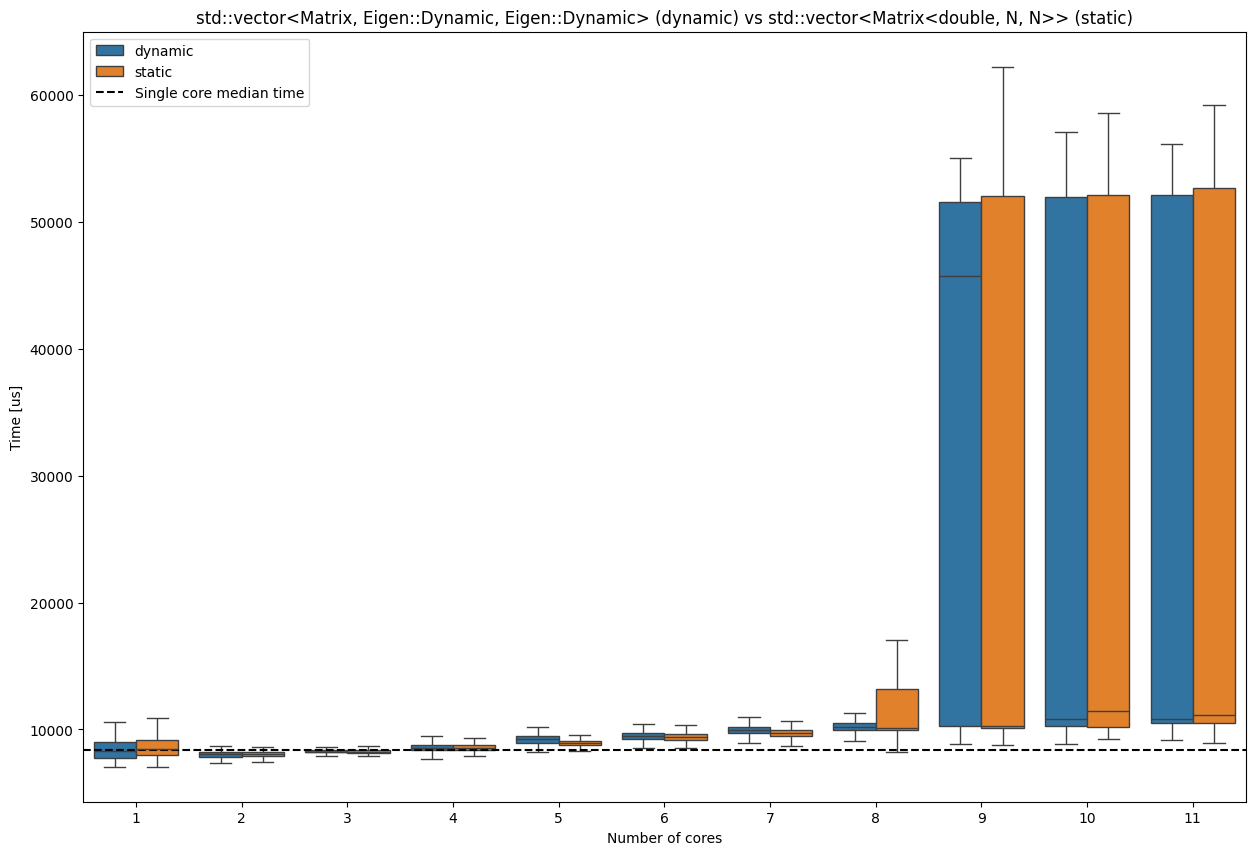

In [11]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = True
access_type = "dynamic"

sns.boxplot(
    data=df[(df["sync_mem"] == sync_mem) & (df["nthreads"] < 12)],
    x="nthreads",
    y="time",
    hue="alignment",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[(df_base["sync_mem"] == sync_mem) & (df_base["sync_mem"] == sync_mem)][
    "time"
].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="std::vector<Matrix, Eigen::Dynamic, Eigen::Dynamic> (dynamic) vs std::vector<Matrix<double, N, N>> (static)",
)

legend = axs.legend()

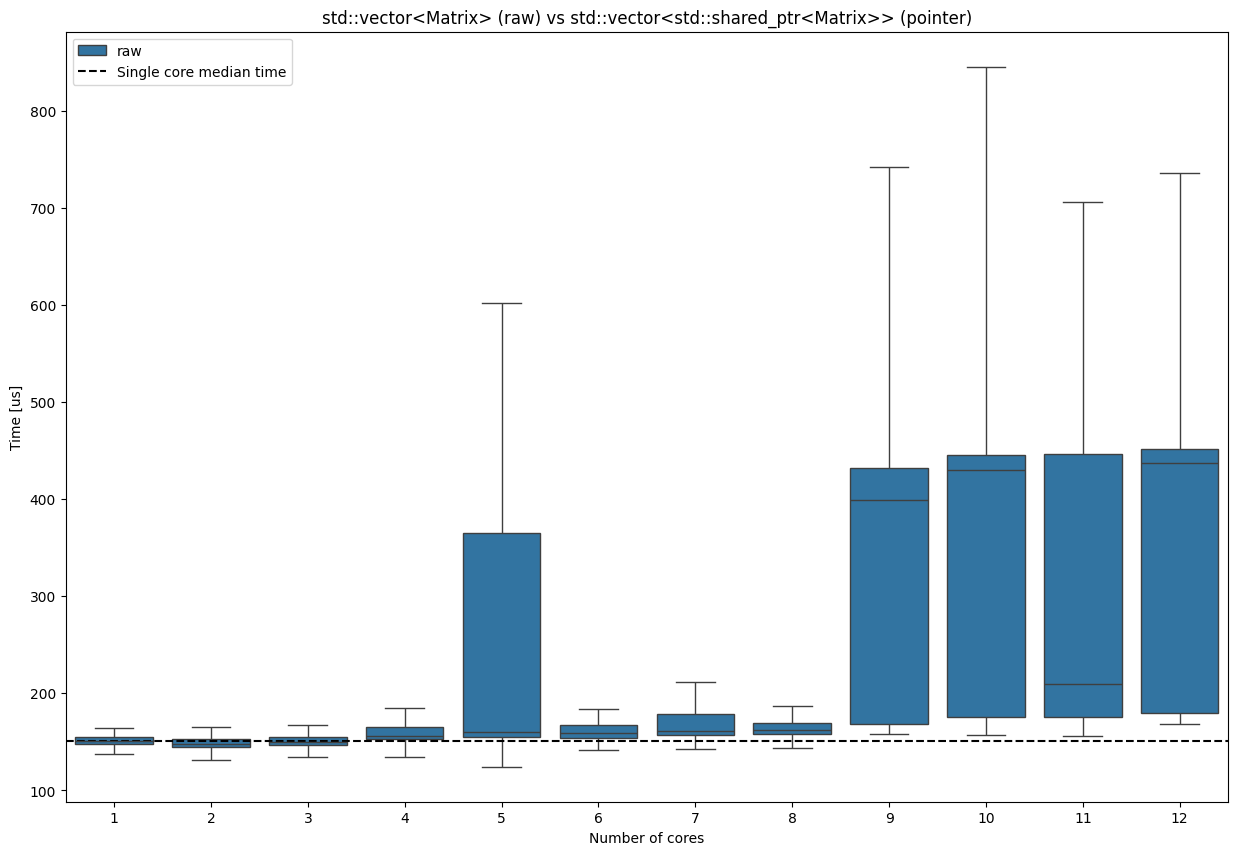

In [8]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = False
access_type = "raw"
alignment_type = "dynamic"

sns.boxplot(
    data=df[(df["sync_mem"] == sync_mem) & (df["alignment"] == alignment_type)],
    x="nthreads",
    y="time",
    hue="access",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[
    (df_base["sync_mem"] == sync_mem) & (df_base["alignment"] == alignment_type)
]["time"].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="std::vector<Matrix> (raw) vs std::vector<std::shared_ptr<Matrix>> (pointer)",
)

legend = axs.legend()

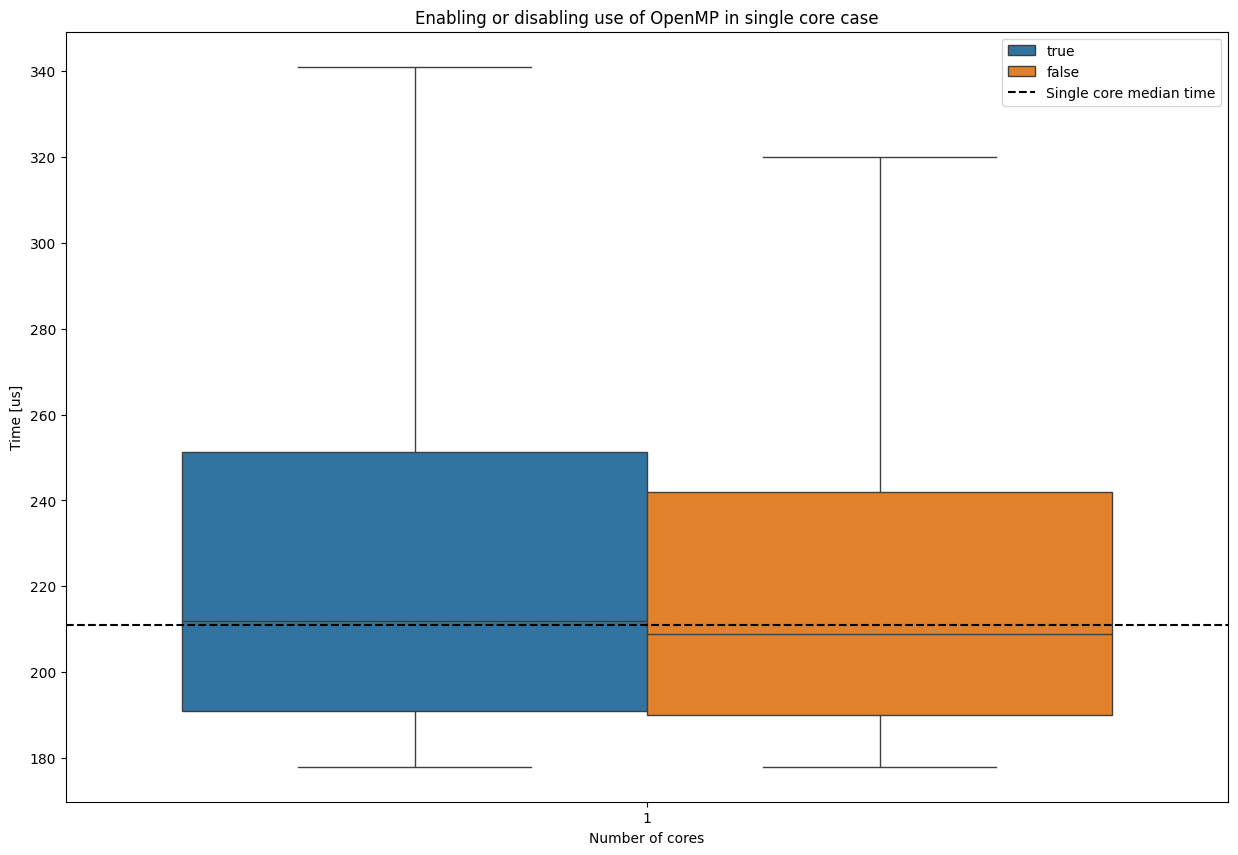

In [9]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = False
access_type = "raw"
alignment_type = "static"
access = "raw"

sns.boxplot(
    data=df[
        (df["sync_mem"] == sync_mem)
        & (df["alignment"] == alignment_type)
        & (df["access"] == access)
        & (df["nthreads"] == 1)
    ],
    x="nthreads",
    y="time",
    hue="use_openmp",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[
    (df_base["sync_mem"] == sync_mem) & (df_base["alignment"] == alignment_type)
]["time"].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="Enabling or disabling use of OpenMP in single core case",
)

legend = axs.legend()

In [25]:
import subprocess
import os

environment = os.environ.copy()

benchmark_path = "../../../build/g++/experiments/pure_eigen_openmp/pure_openmp"
csv_path = "/tmp/bench.csv"


outputs = []
n_iter = 20

for i in tqdm(range(n_iter)):
    for mem_sync in ("false", "true"):
        for cores in range(1, 20):
            for use_openmp in [True] if cores != 1 else [True, False]:
                for proc_bind in [True, False]:
                    environment["OMP_PROC_BIND"] = str(proc_bind).lower()
                    subprocess.call(
                        [
                            benchmark_path,
                            str(cores),
                            csv_path,
                            mem_sync,
                            str(use_openmp).lower(),
                        ],
                        env=environment,
                    )
                    df = pd.read_csv(csv_path)
                    df["use_openmp"] = use_openmp
                    df["proc_bind"] = proc_bind
                    outputs.append(df)

df = pd.concat(outputs)

time_str = time.strftime("%Y%m%d-%H%M")
with open(f"pure_eigen_openmp_{n_iter}_iter_{time_str}.pickle", "wb") as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/20 [00:00<?, ?it/s]

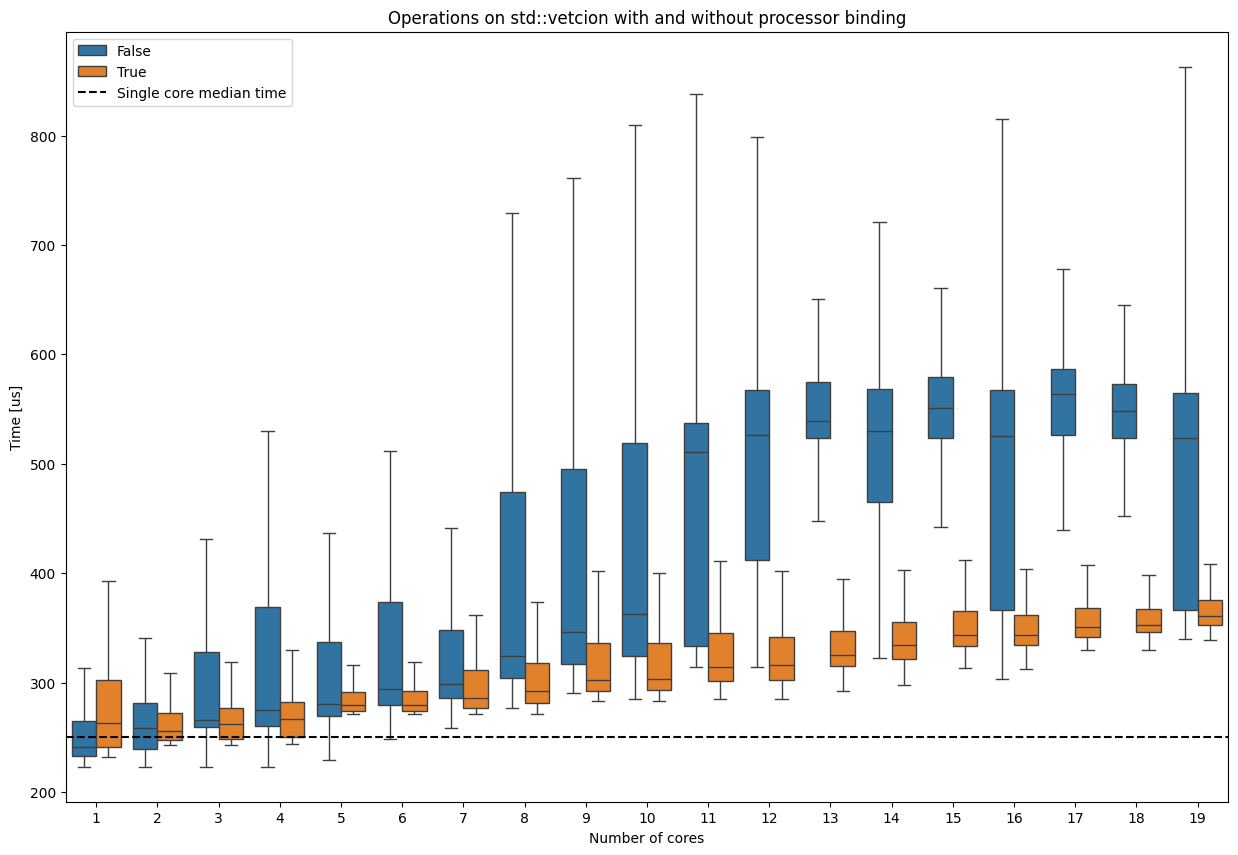

In [ ]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = True
use_openmp = True

df_case = df[
    (df["nthreads"] < 20)
    & (df["use_openmp"] == use_openmp)
    & (df["sync_mem"] != sync_mem)
]

sns.boxplot(
    data=df_case,
    x="nthreads",
    y="time",
    hue="proc_bind",
    showfliers=False,
    ax=axs,
)


line = df_case[df_case["nthreads"] == 1]["time"].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="Operations on std::vetcion with and without processor binding",
)

legend = axs.legend()

In [ ]:
import subprocess
import os

environment = os.environ.copy()

build_script_path = "../../../scripts/build.sh"
csv_path = "/tmp/bench.csv"

outputs = []
n_iter = 100

for compiler in ["g++", "clang++-15", "icpx"]:
    subprocess.call(
        [
            build_script_path,
            compiler,
        ],
    )
    benchmark_path = (
        f"../../../build/{compiler}/experiments/pure_eigen_openmp/pure_eigen_openmp"
    )
    for i in tqdm(range(n_iter)):
        for cores in range(1, 12):
            for proc_bind in [True, False]:
                environment["OMP_PROC_BIND"] = str(proc_bind).lower()
                if compiler == "icpx":
                    environment["LD_LIBRARY_PATH"] = (
                        f"/opt/intel/oneapi/compiler/latest/lib:{environment['LD_LIBRARY_PATH']}"
                    )
                subprocess.call(
                    [
                        benchmark_path,
                        str(cores),
                        csv_path,
                        "true",
                        "dynamic",
                        str(cores != 1).lower(),
                    ],
                    env=environment,
                )
                df = pd.read_csv(csv_path)
                df["proc_bind"] = proc_bind
                df["compiler"] = compiler
                outputs.append(df)

df = pd.concat(outputs)

++++ realpath ../../../scripts/build.sh
+++ dirname /home/gepetto/benchmark/scripts/build.sh
++ dirname /home/gepetto/benchmark/scripts
+ BUILD_PATH=/home/gepetto/benchmark
+ cmake -B /home/gepetto/benchmark/build/g++ -DCMAKE_BUILD_TYPE=RelWithDebInfo -DBUILD_WITH_NTHREADS=20 '-DCMAKE_C_FLAGS=-O3 -march=native' '-DCMAKE_CXX_FLAGS=-O3 -march=native' -DCMAKE_CXX_COMPILER=g++ -Wno-dev -Wall
CMake Error: The source directory "/home/gepetto/benchmark/experiments/pure_eigen_openmp/notebooks" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.


  0%|          | 0/10 [00:00<?, ?it/s]

++++ realpath ../../../scripts/build.sh
+++ dirname /home/gepetto/benchmark/scripts/build.sh
++ dirname /home/gepetto/benchmark/scripts
+ BUILD_PATH=/home/gepetto/benchmark
+ cmake -B /home/gepetto/benchmark/build/clang++-15 -DCMAKE_BUILD_TYPE=RelWithDebInfo -DBUILD_WITH_NTHREADS=20 '-DCMAKE_C_FLAGS=-O3 -march=native' '-DCMAKE_CXX_FLAGS=-O3 -march=native' -DCMAKE_CXX_COMPILER=clang++-15 -Wno-dev -Wall
CMake Error: The source directory "/home/gepetto/benchmark/experiments/pure_eigen_openmp/notebooks" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.


  0%|          | 0/10 [00:00<?, ?it/s]

++++ realpath ../../../scripts/build.sh
+++ dirname /home/gepetto/benchmark/scripts/build.sh
++ dirname /home/gepetto/benchmark/scripts
+ BUILD_PATH=/home/gepetto/benchmark
+ cmake -B /home/gepetto/benchmark/build/icpx -DCMAKE_BUILD_TYPE=RelWithDebInfo -DBUILD_WITH_NTHREADS=20 '-DCMAKE_C_FLAGS=-O3 -march=native' '-DCMAKE_CXX_FLAGS=-O3 -march=native' -DCMAKE_CXX_COMPILER=icpx -Wno-dev -Wall
CMake Error: The source directory "/home/gepetto/benchmark/experiments/pure_eigen_openmp/notebooks" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.


  0%|          | 0/10 [00:00<?, ?it/s]

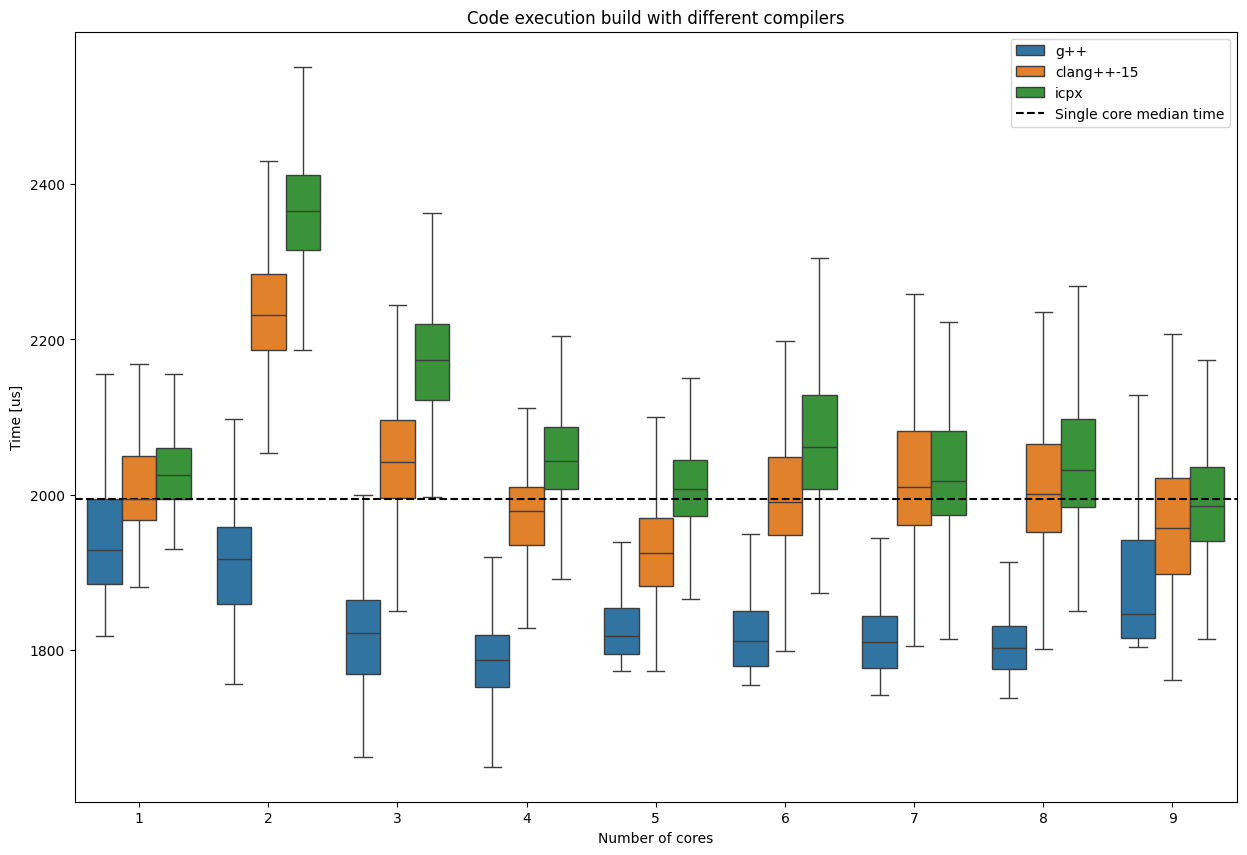

In [65]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

proc_bind = True

df["parallel"] = df["whole"] - df["single_core"]

y = "whole"

sns.boxplot(
    data=df[(df["proc_bind"] == proc_bind) & (df["nthreads"] < 10)],
    x="nthreads",
    y=y,
    hue="compiler",
    showfliers=False,
    ax=axs,
)

df_base = df[df["nthreads"] == 1]
line = df_base[(df_base["proc_bind"] == proc_bind)][y].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="Code execution build with different compilers",
)

legend = axs.legend()